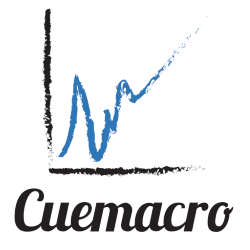

# Populate databases for tcapy

**Saeed Amen / Founder of Cuemacro**

https://www.cuemacro.com / saeed@cuemacro.com / @saeedamenfx / All material is copyright Cuemacro / 2020

## Introduction

In order for tcapy to work best it needs databases to ingest trade data and high frequency market data. Here we illustrate how to download market data from external sources, and how to populate your market tick database with it. We also show how to populate your trade database with your own trade/order data from CSV files. We also show how you can dump trade/order data from your database too via tcapy.

This tutorial assumes that users are using databases for MySQL to store their trade/order data and MongoDB for their market data and also using Ubuntu/WSL, on `localhost`. You can setup both MySQL and MongoDB on Windows if you prefer.

Whilst our focus here is on MySQL and MongoDB, note that tcapy supports several databases, via adapters:

* trade/order data - Microsoft SQL Server, MySQL, SQLite
* market data - Arctic/MongoDB, PyStore, InfluxDB and kdb+/q

You can also read trade/order and market data from flat files (CSV, Parquet or H5) or direct from external sources. However, we would strongly recommend, in particular for your market data, to download from your external source and then dump in your database. For trade/order data, it is also more convenient to use a database, rather than using CSVs.

If running locally, we are assuming that users have already installed MySQL/MongoDB on their Linux box, using `install_mysql.sh` and `install_mongodb.sh`, which is also triggered by `install_all_tcapy.sh`. You also need to make sure the databases have been started locally, using `restart_db.py`.

You can of course use databases which are not installed locally, in which case you won't need to install locally, but you will still need the IP, usernames and passwords to access them. To begin with, as with the other notebooks, let's set our paths. We are assuming that we are running the front end on Windows and the backend on WSL/Ubuntu.

In [1]:
import sys
import os

windows_tcapy_path = 'e:/cuemacro/tcapy' # Windows platform
linux_tcapy_path = '/home/tcapyuser/cuemacro/tcapy' # Linux platform
local_test_data_path = '../test/resources/' # Windows platform
remote_test_data_path = '../test/resources/' # WSL drive

# For dumping market data files
# Assuming Windows platform (you might have to change these paths)
# wsl$ gives us access to the WSL/Ubuntu drive on Windows
# Make sure whatever paths you add exist!
csv_folder = '\\\\wsl$\\Ubuntu\\data\\csv_dump\\'
temp_data_folder = "\\\\wsl$\\Ubuntu\\data\\temp\\"
temp_large_data_folder = "\\\\wsl$\\Ubuntu\\data\\csv_dump\\large\\"

# Assuming the front end is on Windows
sys.path.insert(0, windows_tcapy_path)

from tcapy.conf.constants import Constants

constants = Constants()

# Should we download the tick data or upload to Arctic? (this will take ages!)
download_tick_data = False
upload_tick_data = False

Let's also define the data vendor we are using (by default `dukascopy`) and also which database we shall use for trade/order data `mysql`. We'll also define our market database as `arctic` but you can also select `pystore` too. In both cases, we ensure that we are reading/writing to the test harness database/tables, rather than the main tables. Obviously, for production purposes, you would not use the databases or tables with `test_harness`, however, for tutorials etc, it is better to write in separate tables. We also even advise setting up a totally different database for testing purposes, rather than using a production database.

In [2]:
data_vendor = 'dukascopy' # 'ncfx' or 'dukascopy'

# 'ms_sql_server' or 'mysql' or 'sqlite'
sql_database = 'mysql'
trade_data_database_name = 'trade_database_test_harness'

# 'arctic' or 'pystore'
market_database = 'arctic'
market_data_database_name = 'market_data_table_test_harness'
data_vendor_test_harness = 'testharness'

# Change paths as appropriate
pystore_path = '/data/pystore' # Linux
pystore_path = '\\\\wsl$\\Ubuntu\\data\\pystore' # Windows

from tcapy.data.databasesource import DatabaseSourceArctic, DatabaseSourcePyStore

if data_vendor == 'ncfx':
    from tcapy.data.databasepopulator import DatabasePopulatorNCFX as DatabasePopulator

    tickers = constants.ncfx_tickers
elif data_vendor == 'dukascopy':
    from tcapy.data.databasepopulator import DatabasePopulatorDukascopy as DatabasePopulator
    
    tickers = constants.dukascopy_tickers

if sql_database == 'ms_sql_server':
    from tcapy.data.databasesource import DatabaseSourceMSSQLServer as DatabaseSource
elif sql_database == 'mysql':
    from tcapy.data.databasesource import DatabaseSourceMySQL as DatabaseSource
elif sql_database == 'sqlite':
    from tcapy.data.databasesource import DatabaseSourceSQLite as DatabaseSource
    
if market_database == 'arctic':
    market_data_database_table = 'market_database_test_harness'
    database_source_market = DatabaseSourceArctic(postfix=data_vendor_test_harness)
    
elif market_database == 'pystore':
    market_data_database_table = 'market_database_test_harness'
    database_source_market = DatabaseSourcePyStore(postfix=data_vendor_test_harness)

Let's also define the trade key mappings to underlying SQL database tables too.

In [3]:
sql_trade_order_mapping = {
    'ms_sql_server' :   {'trade_df' : '[dbo].[trade]',      # Name of table which has broker messages to client
                         'order_df' : '[dbo].[order]'},             # Name of table which has orders from client
    'mysql':            {'trade_df': 'trade_database_test_harness.trade',   # Name of table which has broker messages to client
                         'order_df': 'trade_database_test_harness.order'},  # Name of table which has orders from client
    'sqlite':           {'trade_df': 'trade_table',  # Name of table which has broker messages to client
                         'order_df': 'order_table'}  # Name of table which has orders from client
}

# Format of input data for tcapy

tcapy expects data to be a certain format when input. If it isn't quite the right format, you can change it beforehand, or use `DataNorm` to change on the fly. We strongly recommend looking at sample CSV files in the `tests_harness_data` folder which have trade data (`small_test_trade_df.csv`) and order data (`small_test_order_df.csv`).

Note, that the more fields we have recorded, the more scope it gives us for doing TCA. For example, the `venue` field is optional but if it is there, we can also slice and dice trade data by venue, to understand if some venues are more costly than others. 

If we have very limited data, we have less scope in what we do for TCA. Also the granularity and quality of the data is important. For example, having very inaccurate timestamps can make TCA, means that any benchmark we find will also be subject to an inaccurate timestamp. This can happen when trades are booked manually after a trade has taken place.

## Trade data format

We assume that trade messages are points in time, which are returned by our liquidity provider. These can a range of messages, usually `trade` fills, but they can also be cancel messages (in which case we would not for example have a populated `executed_price` field etc.). We give some of the fields here, note that we can have many more than this, and use those to filter trades. 

Note that tcapy will add many calculated fields to this, such as converting to the notional to the reporting currency (typically USD), benchmarks (such as mid price), metrics (such as slippage) etc.

* `Date` - index - date/time of the message
* `id` - event identifier
* `ticker` - asset
* `side` - side of the trade (eg. +1 for buy and -1 for sell)
* `executed_notional` - amount actually executed
* `executed_price` - price at which trade has been dealt
* `notional_currency` - currency in which notional is expressed
* `event_type` - trade, cancel, cancel/replace or placement
* optional fields
    * `ancestor_pointer_id` - pointing to the order which this trade is part (if orders exist in the dataset)
    * `broker_id` - name of the liquidity provider
    * `venue` - venue where trade was executed
    * `algo_id` - name of the algo used (eg. `manual` or `TWAP` etc.)
    * `trader_id` - which trader executed trade
    * `portfolio_id` - which internal portfolio is the trade for
    * `portfolio_manager_id` - which portfolio manager is this for

## Order data format

You can also use order data in tcapy. Orders are sent by the client to their liquidity provider. They have start and end times and can include multiple trade events. Here we discuss some of the fields specific to orders. As with trades, tcapy will add additional calculated fields, such as `executed_notional` based upon the underlying trade fills in an order, and also `executed_price` calculated as the average execution price of the trade fills.

* `benchmark_date_start` - start time of order
* `benchmark_date_end` - end time of order
* optional fields
    * `order_notional` - total amount of notional from the order

## Market data format

High frequency market data is used as our benchmark in tcapy. Typically, this is going to be quote data. We clearly can't use our own trade data as a benchmark, as this is going to result in circular analysis. However, if we have access to a large database of trade data from many different counterparties, we could construct a benchmark out of that.

Below, we give some of the fields which you can have in your market data for use in tcapy. At the very least we need to have a `mid` market quote and this is typically what we'd use as a benchmark

* `Date` - date/time of the tick
* `mid` - mid market quote, which can be our proxy for the reference price
* `bid` - bid quote
* `ask` - ask quote

tcapy can use bid/ask quotes as benchmark for selling/buying trades respectively, although, by default it will select the `mid` field. For orders, tcapy can construct benchmarks like TWAP on the fly, or VWAP, if you also have volume data (using `BenchmarkTWAP` and `BenchmarkVWAP` classes). 

# MySQL for trade/order data

Here we discuss how to add users to the MySQL database and also how to upload/dump data from your SQL database.

## Adding users

Once MySQL installed, you are likely to want to create a user to access it. In this case, we assume the user is `tcapyuser`. In practice, you may wish to limit the precise privilages. The first step is to run the mysql shell, that will allow us to run commands on the database

    sudo mysql

Let's add a user `tcapyuser` that can access the mysql database. In practice, we may wish to limit their priviliges! In this instance, we will only allow the user to login from the localhost. This [guide](https://medium.com/@harshityadav95/installing-mysql-in-ubuntu-linux-windows-subsystem-for-linux-from-scratch-d5771a4a2496) summarises how to install MySQL on Ubuntu/WSL and also the steps you can take to secure it.

    CREATE USER 'tcapyuser'@'localhost' IDENTIFIED BY 'password';
    GRANT ALL PRIVILEGES ON * . * TO 'tcapyuser'@'localhost';
    FLUSH PRIVILEGES;

We can also change the passwords of a user by running the following.

    SET PASSWORD FOR 'tcapyuser'@'localhost' = 'password';

We can also create the `trade_database` database that we'll use to store trade/order data. You should also create `trade_database_test_harness` if you want to run any tests or execute the code in this notebook. If you want to setup SQL Server or SQLite, you'll also need to create databases in those, as tcapy doesn't by default attempt to create databases (it will create the appropriate tables though automatically, if necessary).

    CREATE DATABASE trade_database;
    SHOW DATABASES;

MySQL can have issues with large SQL inserts, increasing the `max_allowed_packet` parameter can help.

    Select @@global.max_allowed_packet;
    SET GLOBAL max_allowed_packet=1073741824

Default location for the data in MySQL is `/var/lib/mysql/` on Ubuntu. You can configure it for a different location.

## Configuring tcapy to interact with your MySQL database

You will likely need to edit `constants.py` to make sure it is pointing to the right SQL database. Also make sure you add any credentials to a new file `constantscred.py`, which should not be added to version control. Below we've shown some of the parameters you may need to change. Microsoft SQL database has similar parameters

    ## MySQL
    mysql_host = '127.0.0.1'
    mysql_port = '3306'

    mysql_trade_data_database_name = 'trade_database'

    mysql_username = 'OVERWRITE_IN_ConstantsCred'
    mysql_password = 'OVERWRITE_IN_ConstantsCred'

    mysql_dump_record_chunksize = 10000    # Making the chunk size very big for MySQL can slow down inserts significantly

    mysql_trade_order_mapping = OrderedDict(
        [('trade_df', 'trade_database.trade'),     # Name of the table which holds broker messages to clients
         ('order_df', 'trade_database.order')])    # Name of the table which has orders from client

# SQLite for trade/order data

tcapy also supports SQLite for storing trade/order data. SQLite is basically a flat file database, which is stored in a single file on your computer. If you are the only user, it can be an easy way to setup a database. SQLite is included in Python, so we don't need to install it separately unlike for example MySQL. The first thing you need to do is to activate your `py36tca` Python environment. We can do this by running `source /home/tcapyuser/cuemacro/tcapy/batch_scripts/linux/installation/activate_python_environment.sh` on Linux or running `activate_python_environment.bat` on Windows. Then we create a folder to house our SQL database and then run `sqlite3` from the Anaconda prompt to create `trade_database.db`. If you want to run the tcapy tests or execute the code in this notebook, you can also create `trade_database_test_harness.db`.

    mkdir -p /home/tcapyuser/db
    sqlite3 /home/tcapyuser/db/trade_database.db
    >.quit

# Uploading trade/order data to SQL database

In this instance we show how to upload trade/order CSV into the database tables (`trade` and `order`). Note that the database table names differ from the nicknames `trade_df` and `order_df` that we usually use. For simplicity, it is probably easier simply to name everything `trade_df` and `order_df`, but if you have an existing database, we recognise you might not be able to change table names easily. Warning this will overwrite your `trade` and `order` tables!! This code is generic so will work with all the supported SQL databases used.

In [4]:
# Where are the trade/order CSVs stored, and how are they mapped?
# This assumes you have already generated these files!
csv_sql_table_trade_order_mapping = {'trade': os.path.join(local_test_data_path, 'small_test_trade_df.csv'),
                                     'order': os.path.join(local_test_data_path, 'small_test_order_df.csv'),
                                    }

# Get the actual table names in the database which may differ from "nicknames"
trade_order_mapping = constants.trade_order_mapping[sql_database]

# To interact with our SQL database
database_source = DatabaseSource(trade_data_database_name=trade_data_database_name)

# Upload each CSV to the associated table (replacing it!)
for key in csv_sql_table_trade_order_mapping.keys():
    database_source.convert_csv_to_table(
            csv_sql_table_trade_order_mapping[key], None, key, database_name=trade_data_database_name,
            if_exists_table='replace')

2020-04-08 19:19:59,961; INFO:tcapy.data.databasesource: Parsing e:/Remote/tcapy/tests_harness_data/small_test_trade_df.csv before database dump for table trade (databasesource.py:1036)
2020-04-08 19:19:59,987; DEBUG:tcapy.data.databasesource: About to write to mysql database... (databasesource.py:1101)
2020-04-08 19:20:00,168; DEBUG:tcapy.data.databasesource: No empty strings in column broker_id (databasesource.py:500)
2020-04-08 19:20:00,169; DEBUG:tcapy.data.databasesource: No empty strings in column venue (databasesource.py:500)
2020-04-08 19:20:00,171; DEBUG:tcapy.data.databasesource: No empty strings in column algo_id (databasesource.py:500)
2020-04-08 19:20:00,291; INFO:tcapy.data.databasesource: Parsing e:/Remote/tcapy/tests_harness_data/small_test_order_df.csv before database dump for table order (databasesource.py:1036)
2020-04-08 19:20:00,300; DEBUG:tcapy.data.databasesource: About to write to mysql database... (databasesource.py:1101)
2020-04-08 19:20:00,369; WARNING:tcapy.

(mysql.connector.errors.ProgrammingError) 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'order ADD CONSTRAINT order_PK_trade PRIMARY KEY (`date`, id, ticker)' at line 1
[SQL: ALTER TABLE order ADD CONSTRAINT order_PK_trade PRIMARY KEY (`date`, id, ticker)]
(Background on this error at: http://sqlalche.me/e/f405)


## Dumping trade/order data to CSV and Parquet

We can use the `DatabaseSource` objects to read back from our SQL database. Note, that the data here, won't have undergone any normalization process, which is typically done during TCA calculations by the `DataNorm` object.

In [5]:
# Map the "nicknames" to the CSV dumping output
csv_trade_order_mapping_dump = {'trade_df': os.path.join(local_test_data_path, 'small_test_trade_df_dump.csv'),
                                'order_df': os.path.join(local_test_data_path, 'small_test_order_df_dump.csv'),
                                }

# Get the actual table names in the database which may differ from "nicknames"
trade_order_mapping = constants.trade_order_mapping[sql_database]

database_source = DatabaseSource(trade_data_database_name=trade_data_database_name)

for k in trade_order_mapping.keys():
    trade_order_df = database_source.fetch_trade_order_data(table_name=trade_order_mapping[k])
    trade_order_df.to_csv(csv_trade_order_mapping_dump[k])
    trade_order_df.to_parquet(csv_trade_order_mapping_dump[k].replace('csv', 'parquet'))

2020-04-08 19:20:00,448; DEBUG:tcapy.data.databasesource: Excecuted mysql query: select *  from trade_database.trade , 660 returned (databasesource.py:959)
2020-04-08 19:20:00,492; DEBUG:tcapy.data.databasesource: Excecuted mysql query: select *  from trade_database.order , 322 returned (databasesource.py:959)


# Arctic/MongoDB for market tick data

Here we discuss how to add users to the database, how to download data from Dukascopy and also how to upload tick data to Arctic/MongoDB.

## Increasing open file limit on Linux for MongoDB

MongoDB ends up opening many files at the same time. However, on Linux typically the `nofile` setting is quite low by default. In order to make MongoDB stable, it is recommended to increase the number of open files allowed. By default, during tcapy's installation `increase_file_limits.sh` is run which copies a modified version of `limits.conf` to `/etc/security/limits.conf` which increases the `nofile` parameters for `root` user (which is the default one in tcapy for running MongoDB). It also overwrites `/etc/pam.d/common-session` and `/etc/pam.d/common-session-noninteractive` to ensure that the `limits.conf` is observed for the root user.

Note, that you may wish to use different users such as the `mongodb` user to run your instance of MongoDB, and also to run MongoDB on Linux a service at startup, as opposed to running it via `restart_db.sh`. However, this isn't the default usage with tcapy and would require changing the configuration.

To check the `nofile` parameter has been currently set for the `root` user, you can run:

    sudo su
    ulimit -n
    
The output should be `100000` if the above script has been run. Note, that it has only been fully tested on Ubuntu at present.

If you do not increase the open file limit, you will likely experience a lot of issues, when trying to access MongoDB. This link in the [MongoDB explains more](https://docs.mongodb.com/manual/reference/ulimit/) and this article explains how to [tune MongoDB for a large number of users](https://www.mongodb.com/blog/post/tuning-mongodb--linux-to-allow-for-tens-of-thousands-connections) including a discussion of the open files point.

## Adding users

Once installed, you may wish to create various users for accessing MongoDB, by typing in the following commands into the Mongo shell. We can start the Mongo shell by running.

    sudo mongo

We can add a root user called `admin_root`. Generally, it is advisable to limit root access to the database.

    use admin
    db.createUser(
      {
        user: "admin_root",
        pwd: "password",
        roles: ["root"]
      }
    )

Let's create a user `tcapyuser` who will be the one mainly accessing the MongoDB database via tcapy. Again, as with mysql, we might wish to reduce the privilages of the user.

    use admin
    db.createUser(
          {
            user: "tcapyuser",
            pwd: "password",
            roles: [ { role: "userAdminAnyDatabase", db: "admin" }, 
                 { role: "dbAdminAnyDatabase", db: "admin" }, 
                 { role: "readWriteAnyDatabase", db: "admin" } ]
          }
    )

You can also change passwords of user.

    use admin
    db.changeUserPassword("admin_root", "password")

## Storage engines for Arctic/MongoDB

tcapy uses [Arctic](https://github.com/man-group/arctic) which is Man AHL's open source Python library to intreact with MongoDB. It essentially takes Pandas DataFrame, and then compresses them before dumping them into MongoDB. It is very fast for fetching and dumping large amounts of time series data. The speed is relatively to several points, first because of the compression, it is less impacted by IO limits. Furthermore, because of the compression there is less overhead when accessing MongoDB over a network. 

There are several different storage engines in Arctic:

* `ChunkStore`
* `VersionStore`
* `TickStore`

Each engine has various different use cases. tcapy supports all three, however, we have opted to make `ChunkStore` the default engine, which stores the data in user defined chunks. 

In our case, our default chunk size is daily, because typically, when using Celery in parallel to fetch data in daily chunks (and caching these daily chunks in Redis), and it should be very fast to get such chunks. In our experience this seems to be quicker than doing the same thing using `VersionStore`.

The precise chunk size you choose, will depend on how you intend to use it. For example, if you wouldn't run tcapy in parallel, then you might consider using larger chunk sizes. In the documentation, the reasons for Arctic speed is discussed in more detail, as well as a [summary of the various storage engines](https://arctic.readthedocs.io/en/latest/).

Note, that you should not try to keep switching between the various storage engines, while using the same identical collection names eg. `market_data_table`. If you intend to use them in together (eg. for benchmarking) it would be better to have different collection names for each storage engine to avoid confusion.

## Configuring tcapy to interact with your MongoDB database

You will likely need to edit `constants.py` to make sure it is pointing to you MongoDB instance. Also make sure you add any credentials to a new file `constantscred.py`, which should not be added to version control. Below we've shown some of the parameters you may need to change.

    ### Arctic/MongoDB
    arctic_host = database_host
    arctic_port = 27017
    arctic_username = 'OVERWRITE_IN_ConstantsCred'
    arctic_password = 'OVERWRITE_IN_ConstantsCred'

    arctic_ssl = False
    arctic_ssl_cert_reqs = ssl.CERT_NONE

    # NOTE: database name not currently used in Arctic
    arctic_market_data_database_name = 'fx'
    arctic_trade_data_database_name = 'fx'
    arctic_market_data_database_table = 'market_data_table'  # Name of the table with market tick data

    arctic_timeout_ms = 10 * 1000  # How many millisections should we have a timeout for in Arctic/MongoDB

    # https://arctic.readthedocs.io/en/latest/ has more discussion on the differences between the
    # various storage engines, and the various pros and cons
    # By default we use 'CHUNK_STORE' with 'D' (daily) bucketing - corresponding to our 'daily' fetching when using
    # with Celery
    arctic_lib_type = 'CHUNK_STORE'  # storage engines: VERSION_STORE or TICK_STORE or CHUNK_STORE (default)

    # 'D' is for daily, you can also choose 'M' and other chunk sizes (depends on how you wish to cache data)
    arctic_chunk_store_freq = 'D'

    arctic_quota_market_data_GB = 80

# Experiementing with PyStore for market tick data

Another choice for storing your market tick data, is [PyStore](https://github.com/ranaroussi/pystore). It isn't strictly speaking a database. It is modelled on Arctic, but instead of using MongoDB as the backend it is Pandas data store, which uses Parquet files on disk, which have been chunked. If you are the only user for the market tick data, PyStore can be an easy to use option (combined with SQLite for the trade/order data). In order to setup PyStore, you just need to make sure that it has access to a folder `/home/tcapyuser/pystore/`, which you can create with:

    mkdir -p /home/tcapyuser/pystore
    
Note, that with pretty much everything else with tcapy, this is fully configurable. You can change the default PyStore dump location in `constants.py`. tcapy also has adapters to use InfluxDB and KDB for accessing market tick data.

*At present we are still our working on our PyStore, and it is highly experimental, in particular, we are trying to speed up the appending of new data, so you may choose to use Arctic for the moment*

# Downloading market tick data from Dukascopy

We are going to show how to download large amounts of tick data from Dukascopy to disk as Parquet files. We are later going to upload these files to MongoDB. Note, the syntax is very similar for NCFX, we just need to instantiate `DatabasePopulatorNCFX` instead of `DatabasePopulatorDukacopy`.

In [6]:
start_date_csv = '01 Jan 2016'; finish_date_csv = '03 Apr 2020'; split_size = 'monthly' # 'daily' or 'monthly'

db_populator = DatabasePopulator(temp_data_folder=temp_data_folder, temp_large_data_folder=temp_large_data_folder,
                                 tickers=tickers)

Now we can kick off the download. This will take a very long time, and hence only do this once! It will dump Parquet files to disk in `monthly` chunks, and will also create smaller temporary files. Having the temporary files is beneficial, so if the download gets interrupted, tcapy will ingest these, rather than redownloading externally. In this case, we have set `write_large_csv` to `False`. Whilst CSV files are universal, they can be very large in file size and slow to parse, compared to Parquet files.

In [7]:
# Writes a CSV/Parquet to disk from data vendor (does not attempt to write anything to the database)
# Will also dump temporary HDF5 files to disk (to avoid reloading them)

if (download_tick_data):
    msg, df_dict = db_populator.download_to_csv(start_date_csv, finish_date_csv, tickers, split_size='monthly',
            csv_folder=csv_folder, return_df=False, remove_duplicates=False, write_large_csv=False,
            write_large_hdf5_parquet=True)

In practice, we'd recommend kicking off the downloading script `dump_data_vendor_to_parquet_csv_hdf5.py` separately, rather than running it in a Jupyter notebook, given the amount of time it takes, and also the amount of log output it generates. In our `csv_dump` folder, we'll end up with a bunch of monthly Parquet files which look like this.

    AUDUSD_dukascopy_2016-01-03_22_00_01.868000+00_002016-01-31_23_59_57.193000+00_00.parquet
    AUDUSD_dukascopy_2016-02-01_00_00_00.055000+00_002016-02-29_23_59_56.657000+00_00.parquet
    AUDUSD_dukascopy_2016-03-01_00_00_00.712000+00_002016-03-31_23_59_50.885000+00_00.parquet

## Uploading market tick data to market database

We can now upload the tick data in the above Parquet (or CSV/HDF5) files to our market database! First we need to define the data source, the tickers we want to upload, and also the format of the data. To make things quicker, I've just filtered for 2017 (mainly because that cover the period of the pregenerated trade/order CSVs in the `tests_harness_data` folder that comes with tcapy).

In [8]:
ticker_mkt = ['EURUSD'] # You can add more tickers, but it will take much longer!

file_extension = 'parquet'  # parquet or csv or h5

# Files dumped by DatabasePopulator look like this
# 'EURUSD_dukascopy_2016-01-03_22_00_01.868000+00_002016-01-31_23_59_57.193000+00_00.parquet'
#
# Assume that ALL TIME IN UTC!
csv_file = [x + '_' + data_vendor + '_*.' + file_extension for x in ticker_mkt]  

# These are all the files with the market tick data
csv_market_data = [os.path.join(csv_folder, x) for x in csv_file]

Now read the Parquet files and upload our market databases (this will take a while!). Note it will overwrite any tickers already in the database from the same data vendor. By default we use `DatabaseSourceArctic` but note we could have changed it to `DatabaseSourcePyStore` earlier.

In [9]:
if upload_tick_data:
    for i in range(0, len(ticker_mkt)):
        ticker = ticker_mkt[i]
        csv_file = csv_market_data[i]

        print('Uploading ' + ticker)
        
        # Very first time, replace whole table, then append
        # Otherwise will overwrite every ticker continuously!
        if i == 0:
            if_exists_table = 'replace'
        else:
            if_exists_table = 'append'
        
        database_source_market.convert_csv_to_table(csv_file, ticker, market_data_database_table,
                                            if_exists_table=if_exists_table, remove_duplicates=False,
                                            if_exists_ticker='replace', date_format=None,
                                            read_in_reverse=False)

2020-04-08 19:20:00,542; INFO:tcapy.data.databasesource: Attempting to load Arctic/MongoDB library: market_database_test_harness CHUNK_STORE (databasesource.py:1881)
2020-04-08 19:20:00,544; INFO:tcapy.data.databasesource: Got Arctic/MongoDB library: market_database_test_harness CHUNK_STORE (databasesource.py:1901)


Uploading EURUSD


2020-04-08 19:20:00,547; INFO:arctic.arctic: Dropping collection: market_database_test_harness (arctic.py:326)
2020-04-08 19:20:00,780; INFO:arctic.arctic: Dropping collection: market_database_test_harness.snapshots (arctic.py:330)
2020-04-08 19:20:00,793; INFO:arctic.arctic: Dropping collection: market_database_test_harness.versions (arctic.py:330)
2020-04-08 19:20:00,810; INFO:arctic.arctic: Dropping collection: market_database_test_harness.ARCTIC (arctic.py:330)
2020-04-08 19:20:00,819; INFO:arctic.arctic: Dropping collection: market_database_test_harness.version_nums (arctic.py:330)
2020-04-08 19:20:01,208; INFO:arctic.chunkstore.chunkstore: Trying to enable sharding... (chunkstore.py:46)
2020-04-08 19:20:01,211; WARNING:arctic.chunkstore.chunkstore: Library created, but couldn't enable sharding: no such command: 'enablesharding'. This is OK if you're not 'admin' (chunkstore.py:50)
2020-04-08 19:20:01,833; INFO:tcapy.data.databasesource: Parsing \\wsl$\Ubuntu\home\tcapyuser\csv_dum

2020-04-08 19:20:38,912; INFO:tcapy.data.databasesource: Parsing \\wsl$\Ubuntu\home\tcapyuser\csv_dump\EURUSD_dukascopy_2018-04-01_21_00_18.456000+00_002018-04-30_23_59_59.599000+00_00.parquet before tick database dump for ticker EURUSD-testharness (databasesource.py:1701)
2020-04-08 19:20:39,906; INFO:tcapy.data.databasesource: Parsing \\wsl$\Ubuntu\home\tcapyuser\csv_dump\EURUSD_dukascopy_2018-05-01_00_00_00.129000+00_002018-05-31_23_59_59.903000+00_00.parquet before tick database dump for ticker EURUSD-testharness (databasesource.py:1701)
2020-04-08 19:20:41,160; INFO:tcapy.data.databasesource: Parsing \\wsl$\Ubuntu\home\tcapyuser\csv_dump\EURUSD_dukascopy_2018-06-01_00_00_00.434000+00_002018-06-29_20_59_56.236000+00_00.parquet before tick database dump for ticker EURUSD-testharness (databasesource.py:1701)
2020-04-08 19:20:42,257; INFO:tcapy.data.databasesource: Parsing \\wsl$\Ubuntu\home\tcapyuser\csv_dump\EURUSD_dukascopy_2018-07-01_21_00_16.014000+00_002018-07-31_23_59_57.465000

There is a script `cache_data_vendor_data.py` which illustrates how to directly populate the database for market tick data from an external download.
* `ONEOFF` - one off downloads from external data sources (either Dukascopy or NCFX) and write directly to the database
* `DAILY_RUN_APPEND` - a regular download from external data sources (either Dukascopy or NCFX) and write directly to the database (note, that Dukascopy won't have the last few weeks of data), typically you could run this once every day, or potentionally on an even highly frequency than that.

In [12]:
%matplotlib inline

import datetime
import pandas as pd

df = database_source_market.fetch_market_data(start_date='01 Jan 2017', finish_date='01 Feb 2017', ticker='EURUSD', 
                                             table_name=market_data_database_table)

df = pd.DataFrame(df.resample('B').last())

if 'mid' not in df.columns:
    df['mid'] = (df['bid'] + df['ask']) / 2.0

df = pd.DataFrame(df['mid'])

print(df)

2020-04-08 23:16:19,004; DEBUG:matplotlib.pyplot: Loaded backend module://ipykernel.pylab.backend_inline version unknown. (pyplot.py:225)
2020-04-08 23:16:19,006; INFO:tcapy.data.databasesource: Attempting to load Arctic/MongoDB library: market_database_test_harness CHUNK_STORE (databasesource.py:1881)
2020-04-08 23:16:19,007; INFO:tcapy.data.databasesource: Got Arctic/MongoDB library: market_database_test_harness CHUNK_STORE (databasesource.py:1901)
2020-04-08 23:16:19,316; DEBUG:tcapy.data.databasesource: Extracted Arctic/MongoDB library: market_database_test_harness for ticker EURUSD-testharness between 2017-01-01 00:00:00 - 2017-02-01 00:00:00 from CHUNK_STORE (databasesource.py:1960)


                                mid
Date                               
2016-12-30 00:00:00+00:00  1.052560
2017-01-02 00:00:00+00:00  1.045770
2017-01-03 00:00:00+00:00  1.041765
2017-01-04 00:00:00+00:00  1.049720
2017-01-05 00:00:00+00:00  1.060400
2017-01-06 00:00:00+00:00  1.052960
2017-01-09 00:00:00+00:00  1.058605
2017-01-10 00:00:00+00:00  1.055230
2017-01-11 00:00:00+00:00  1.059430
2017-01-12 00:00:00+00:00  1.061625
2017-01-13 00:00:00+00:00  1.062750
2017-01-16 00:00:00+00:00  1.060245
2017-01-17 00:00:00+00:00  1.069665
2017-01-18 00:00:00+00:00  1.062825
2017-01-19 00:00:00+00:00  1.065935
2017-01-20 00:00:00+00:00  1.071275
2017-01-23 00:00:00+00:00  1.075930
2017-01-24 00:00:00+00:00  1.072835
2017-01-25 00:00:00+00:00  1.075270
2017-01-26 00:00:00+00:00  1.068355
2017-01-27 00:00:00+00:00  1.071720
2017-01-30 00:00:00+00:00  1.070770
2017-01-31 00:00:00+00:00  1.080100


# Conclusion

We have examined the data formats tcapy expects for trade/order data, as well as market data.

We have seen how to configure both MySQL and MongoDB to work with trade/order data respectively. We've also seen how we can populate a SQL database with trade/order data, using tcapy, and dump it back out. On the market data side, we've investigated how we can read from an external source (Dukascopy) and dump the market data to disk, as well as how to populate MongoDB with it, all via using tcapy. We also talked about how you can use SQLite and PyStore, as flat file alternatives, if you are likely to be the sole user of the tcpay.

It is important you properly maintain your databases for tcapy or indeed for any purpose. If large periods of time have missing tick data for example, you wont' be able to do TCA over those periods. Also having lots of missing trade data in your SQL database, could result in biased results. Data is key to any sort of TCA!